# Number Recognizer

数字を認識するためのモデルを作成します。


* [データロード](#Load-the-Data)
* [モデル構築](#Create-the-Model)
* [学習](#Training-the-Model)
* [評価](#Evaluate-the-Model)
* [保存](#Store-the-Model)


In [8]:
# enable showing matplotlib image inline
%matplotlib inline

## Load the Data

In [9]:
from sklearn import datasets
digits = datasets.load_digits()

print(digits.data.shape)


(1797, 64)


## Create the Model

In [153]:
from sklearn import svm

create_model = lambda : svm.SVC(C=1, gamma=0.0001)
classifier = create_model()

## Training the Model

In [154]:
from sklearn import cross_validation
from collections import namedtuple

DataSet = namedtuple("DataSet", ["data", "target"])

test_size = 0.3  # use 30% of data to test the model
d_train, d_test, t_train, t_test = cross_validation.train_test_split(digits.data, digits.target, test_size=test_size, random_state=0)

training_set = DataSet(d_train, t_train)
test_set = DataSet(d_test, t_test)

print(training_set.data.shape)

classifier.fit(training_set.data, training_set.target)

(1257, 64)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0001,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## Evaluate the Model

In [155]:
from sklearn import metrics

def cal_accuracy(dset):
    predicted = classifier.predict(dset.data)
    score = metrics.accuracy_score(dset.target, predicted)
    return score

print(cal_accuracy(training_set))
print(cal_accuracy(test_set))

0.9769291965
0.974074074074


[ 0.96067416  0.97486034  0.98320896  0.98882682  0.98549107  0.98417132
  0.98564593  0.9825419   0.98014888  0.98325893]
[ 0.6862743   0.80744299  0.83023265  0.87200482  0.8881445   0.90540335
  0.91486828  0.92210106  0.93155361  0.9360117 ]


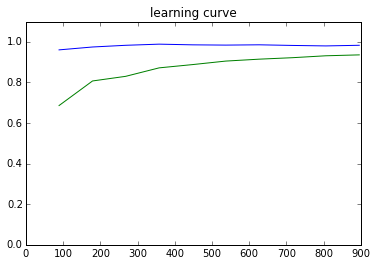

In [156]:
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt
import numpy as np

training_rates = [i / 10 for i in range(1, 11)]

train_sizes, train_scores, valid_scores = learning_curve(create_model(), digits.data, digits.target, train_sizes=training_rates, cv=2)

def print_and_plot(scores):
    mean_scores = np.mean(scores, axis=1)
    print(mean_scores)
    plt.plot(train_sizes, mean_scores)

print_and_plot(train_scores)
print_and_plot(valid_scores)
plt.ylim(0, 1.1)
plt.title("learning curve")

## Tuning the Model

C = 1 :max validation score= 0.4649859943977591
C = 10 :max validation score= 0.49859943977591037
C = 100 :max validation score= 0.49859943977591037
C = 1000 :max validation score= 0.49859943977591037


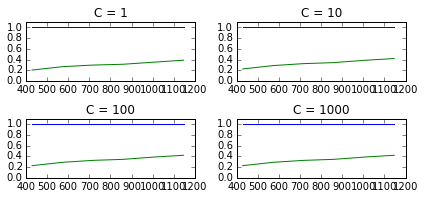

In [40]:
from sklearn.learning_curve import learning_curve
import numpy as np
import matplotlib.pyplot as plt

param_c = [1, 10, 100, 1000]
training_sizes = [s / 10 for s in range(3, 9)]  # see between 30% ~ 90%

for i, c in enumerate(param_c):
    temp_clf = svm.SVC(C=c)
    train_sizes, train_scores, valid_scores = learning_curve(temp_clf, digits.data, digits.target, train_sizes=training_sizes, cv=5)
    
    # show curves in 2 * 2 grid plot
    plt.subplot(3, 2, i + 1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1))
    plt.plot(train_sizes, np.mean(valid_scores, axis=1))
    plt.ylim(0, 1.1)
    plt.title("C = {0}".format(c))
    print("C = {0} :max validation score= {1}".format(c, np.max(valid_scores)))
    
plt.tight_layout()


## Store the Model

In [9]:
from sklearn.externals import joblib

joblib.dump(classifier, "./machine.pkl") 

['./machine.pkl',
 './machine.pkl_01.npy',
 './machine.pkl_02.npy',
 './machine.pkl_03.npy',
 './machine.pkl_04.npy',
 './machine.pkl_05.npy',
 './machine.pkl_06.npy',
 './machine.pkl_07.npy',
 './machine.pkl_08.npy',
 './machine.pkl_09.npy',
 './machine.pkl_10.npy',
 './machine.pkl_11.npy']